In [182]:
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(patchwork))
suppressMessages(library(dplyr))
suppressMessages(library(CellChat))
suppressMessages(library(cowplot))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))
suppressMessages(library(RColorBrewer))

In [69]:
out_dir <- "../../results/09_fib_macrophages/04_viz_cellchat"

if(!dir.exists(out_dir)){
    dir.create(out_dir, recursive = TRUE)
}

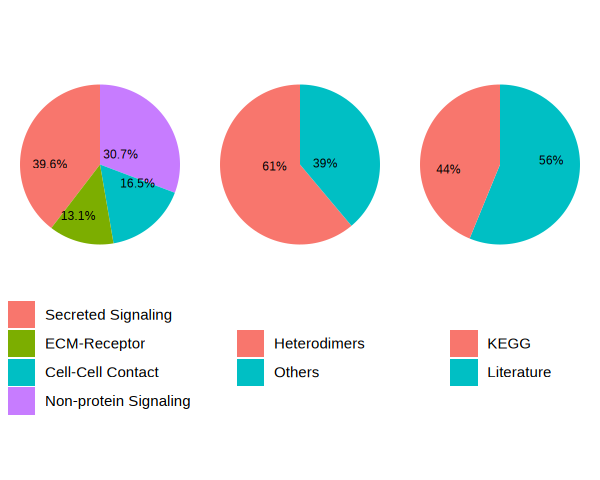

In [70]:
CellChatDB <- CellChatDB.human
showDatabaseCategory(CellChatDB)
CellChatDB.use <- subsetDB(CellChatDB)

In [216]:
df_interaction <- CellChatDB.use$interaction

In [218]:
write.csv(df_interaction, "all_interaction.csv")

In [71]:
cellchat <- readRDS("../../results/09_fib_macrophages/02_run_cellchat/obj.rds")

In [72]:
df.net <- subsetCommunication(cellchat)

df.net$source_type <- ifelse(df.net$source %in% c("Phagocytic", "Pro-inflammatory", "Antigen-presenting"),
                            "Macropages", "Fibroblasts")
df.net$target_type <- ifelse(df.net$target %in% c("Phagocytic", "Pro-inflammatory", "Antigen-presenting"),
                            "Macropages", "Fibroblasts")

df.net$interaction <- paste0(df.net$source_type, "->", df.net$target_type)

# subset network by keeping fib -> mac and mac -> fib
df.net <- subset(df.net, interaction %in% c("Macropages->Fibroblasts", "Fibroblasts->Macropages"))

In [73]:
nrow(df.net)

[1] 393

In [74]:
df.counts <- df.net %>%
    group_by(annotation, interaction) %>%
    dplyr::summarise(count = n())

`summarise()` has grouped output by 'annotation'. You can override using the
`.groups` argument.


In [75]:
df.counts

annotation,interaction,count
<chr>,<chr>,<int>
Cell-Cell Contact,Fibroblasts->Macropages,42
Cell-Cell Contact,Macropages->Fibroblasts,2
ECM-Receptor,Fibroblasts->Macropages,103
Secreted Signaling,Fibroblasts->Macropages,167
Secreted Signaling,Macropages->Fibroblasts,79


In [76]:
write.csv(df.counts, glue::glue("{out_dir}/LR_pair_counts.csv"))

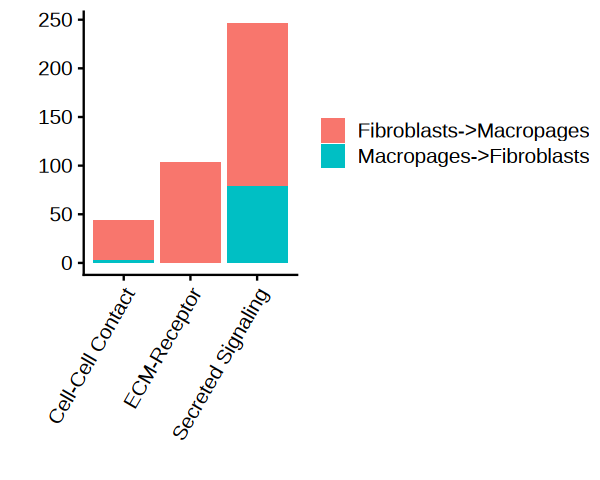

In [77]:
options(repr.plot.height = 4, repr.plot.width = 5)

p <- ggplot(data = df.counts, aes(x = annotation, y = count)) +
    geom_bar(aes(fill = interaction), stat = "identity") +
    xlab("") + ylab("") +
    theme_cowplot() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1),
          legend.title = element_blank())

print(p)

In [171]:
df.count <- as.data.frame(cellchat@net$count)

df.count[1:10, 1:10] <- 0
df.count[11:13, 11:13] <- 0

In [172]:
df.count <- df.count %>%
    tibble::rownames_to_column("source")%>%
    tidyr::pivot_longer(cols = -source, names_to = "target", values_to = "count") %>%
    subset(count > 0) 

df.count1 <- subset(df.count, stringr::str_starts(source, "Fib"))
df.count2 <- subset(df.count, stringr::str_starts(target, "Fib"))

df.count2 <- df.count2[c("target", "source", "count")]
colnames(df.count2) <- c("source", "target", "count")

df.count3 <- rbind(df.count1, df.count2)

df.count3 <- df.count3 %>%
    dplyr::group_by(source, target) %>%
    dplyr::summarise(count = sum(count))

df <- df.count3 %>%
    as.data.frame() %>%
    tidyr::pivot_wider(names_from = "source", values_from = "count") %>%
    tibble::column_to_rownames("target")

df <- df[c("Fib1", "Fib2", "Fib3", "Fib4", "Fib5",
           "Fib6", "Fib7", "Fib8", "Fib9", "Fib10")]

`summarise()` has grouped output by 'source'. You can override using the
`.groups` argument.


In [211]:
df

,Fib1,Fib2,Fib3,Fib4,Fib5,Fib6,Fib7,Fib8,Fib9,Fib10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Antigen-presenting,9,10,6,11,10,15,8,11,21,9
Phagocytic,10,9,7,8,8,15,8,10,21,8
Pro-inflammatory,17,14,12,14,16,25,10,18,41,12


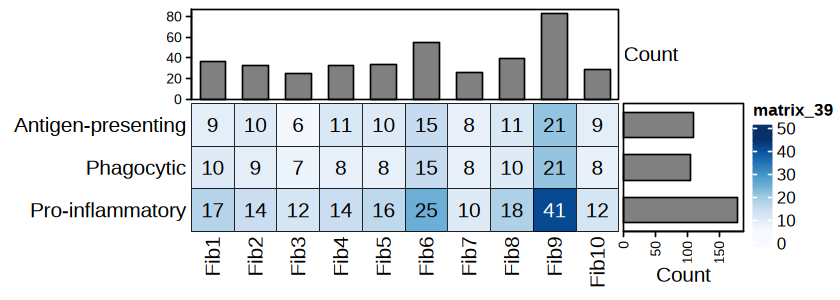

In [210]:
options(repr.plot.height = 2.5, repr.plot.width = 7)

col_fun = colorRamp2(seq(from = 5, to = 45, length = 9), 
                     RColorBrewer::brewer.pal(name = "Blues", n = 9))

column_ha <- HeatmapAnnotation(Count = anno_barplot(colSums(df)), height = unit(0.75, "in"))

row_ha <- rowAnnotation(Count = anno_barplot(rowSums(df)), width = unit(1, "in"))

ht <- Heatmap(as.matrix(df), 
             cluster_rows = FALSE,
             cluster_columns = FALSE,
              row_names_side = "left",
              rect_gp = gpar(col = "black", lwd = 0.5),
              show_column_names = TRUE,
              col = col_fun,
              #col = ArchR::paletteContinuous("whiteBlue", n = 20),
             top_annotation = column_ha,
              right_annotation = row_ha,
             cell_fun = function(j, i, x, y, width, height, fill) {
                if (df[i, j] > 40){
                     grid.text(round(df[i, j], 1), x, y, gp = gpar(fontsize = 12, col="white"))
                    } 
                    else{
                     grid.text(round(df[i, j], 1), x, y, gp = gpar(fontsize = 12, col="black"))
                    }
             
             }
             )

draw(ht)

In [212]:
write.csv(df, glue::glue("{out_dir}/LR_pair_counts_by_subtype.csv"))

Comparing communications on a single object 




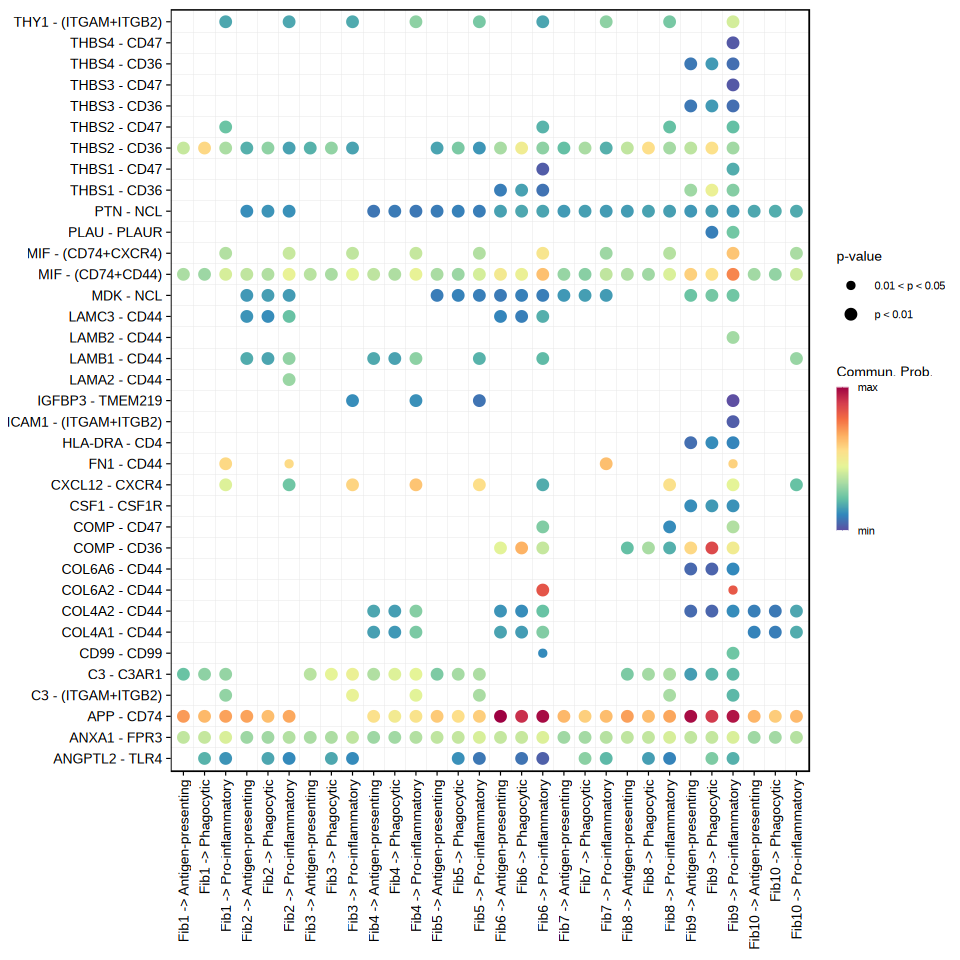

In [214]:
options(repr.plot.height = 8, repr.plot.width = 8)

netVisual_bubble(cellchat, sources.use = c(1:10), targets.use = c(11, 12, 13), remove.isolate = FALSE)